By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook details how to use a pre-trained model to predict antibody binding affinity with ANTIPASTI.

In [1]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import numpy as np
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading a test sample

In [2]:
modes = 'all'
n_filters = 4
filter_size = 4
pooling_size = 1
n_max_epochs = 1044

pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay']
scfv = ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf'] 
pathological += scfv

renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = True # True to retrieve again all the chain lengths 
stage = 'predicting'

test_pdb = '8hn6'
dccm_map_path = 'dccm_maps_full_ags_all/'
test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'
    
preprocessed_data = Preprocessing(dccm_map_path=dccm_map_path, modes=modes, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb)
input_shape = preprocessed_data.test_x.shape[-1]


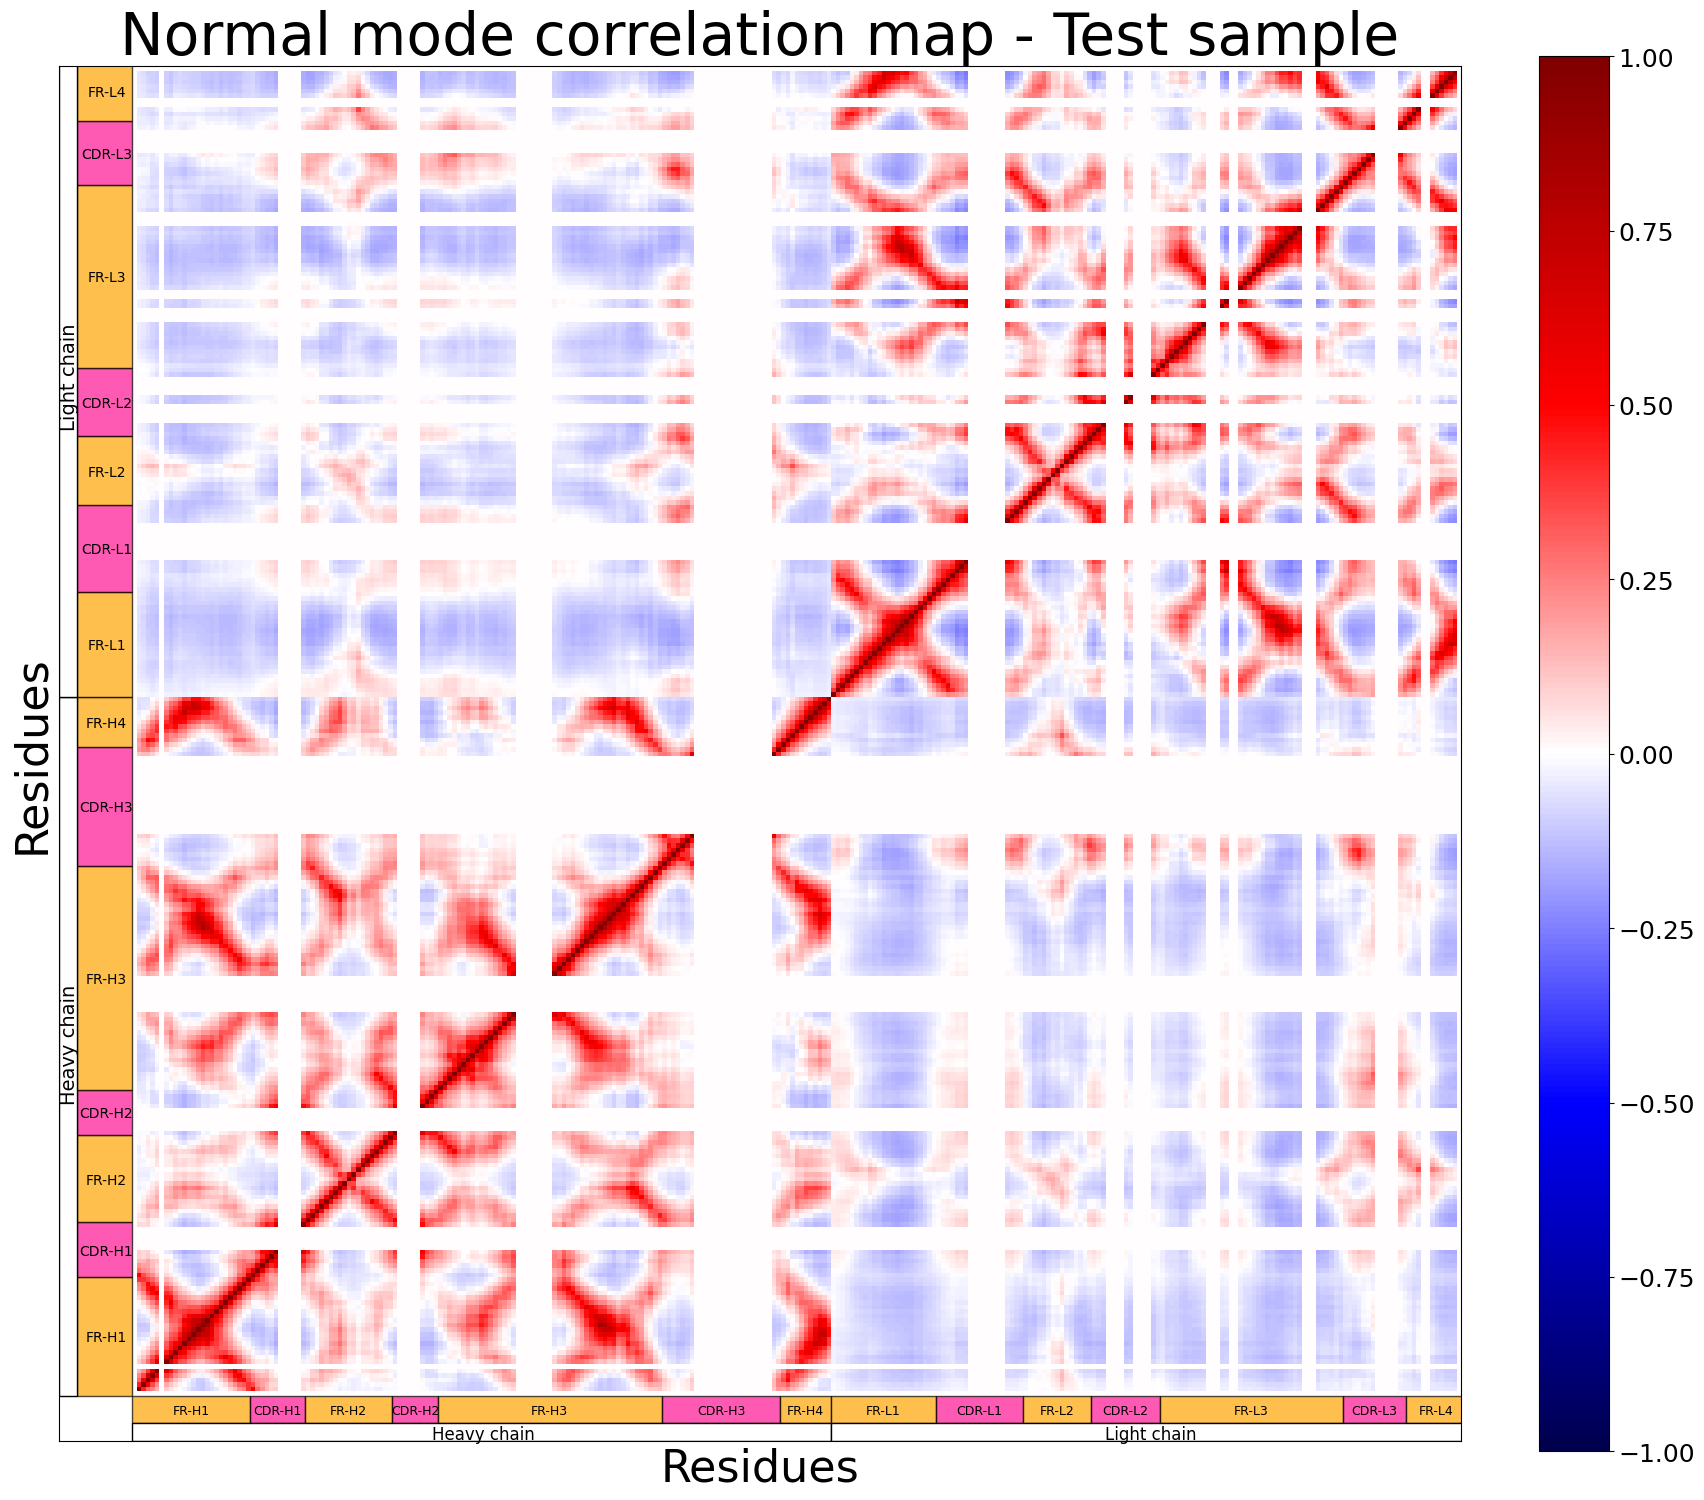

In [3]:
plot_map_with_regions(preprocessed_data, preprocessed_data.test_x, 'Normal mode correlation map - Test sample')

# Loading an ANTIPASTI checkpoint

In [4]:
path = '../checkpoints/full_ags_all_modes/model_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model,optimiser,_,train_losses, test_losses = load_checkpoint(path, input_shape)
model.eval()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=334084, out_features=1, bias=False)
)

# Predicting the binding affinity

In [5]:
# We convert to the torch format
test_sample = torch.from_numpy(preprocessed_data.test_x.reshape(1, 1, input_shape, input_shape).astype(np.float32))

print('The output value is ' + str(model(test_sample)[0].detach().numpy()[0,0]))
print('So the predicted binding affinity is ' + str(10**model(test_sample)[0].detach().numpy()[0,0]))

The output value is -8.3458
So the predicted binding affinity is 4.510239459367876e-09


We can see in [Characterization of RBD-specific cross-neutralizing antibodies responses against SARS-CoV-2 variants from COVID-19 convalescents](https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2023.1160283/full) that the experimentally measured binding affinity is in the order of $10^{-9} \text{M}$.